**Data Cleaning**

In [ ]:
!sudo apt-get install python-dev graphviz libgraphviz-dev pkg-config
!sudo pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
python-dev is already the newest version (2.7.15~rc1-1).
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 34 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.3

In [ ]:
import os
from google.colab import drive
from random import sample
import json
import csv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import datetime
import numpy as np
import math
import graphviz
import pygraphviz
from matplotlib import pylab
import operator
import re
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.algorithms.community import greedy_modularity_communities
import tensorflow as tf
from networkx.algorithms import community
import community
import requests as rq
from bs4 import BeautifulSoup
from bs4.element import Comment
import time
from nltk.corpus import stopwords
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import glob
from scipy.stats import entropy

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
working_directory = 'My Drive/ML Research ListerVosoughi/SMIP/Data'
wd = '/content/gdrive/' + working_directory

Mounted at /content/gdrive


In [ ]:
! git clone https://github.com/MatthewJA/Inverse-Reinforcement-Learning.git

Cloning into 'Inverse-Reinforcement-Learning'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 132 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (132/132), 37.90 KiB | 1.52 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [ ]:
! ls
%cd Inverse-Reinforcement-Learning/
! ls
%cd irl/

2020-01				predictions_week17.0.txt
2020-02				predictions_week18.0.txt
2020-03				predictions_week19.0.txt
2020-04				predictions_week20.0.txt
2020-05				predictions_week21.0.txt
2020-06				predictions_week22.0.txt
2020-07				predictions_week23.0.txt
2020-08				predictions_week26.0.txt
2020-09				predictions_week27.0.txt
all_tweets.tsv			predictions_week28.0.txt
att_mask_final_.txt		predictions_week29.0.txt
encoded_tweets1.txt		predictions_week30.0.txt
encoded_tweets.txt		predictions_week31.0.txt
inputs.pt			predictions_week32.0.txt
Inverse-Reinforcement-Learning	predictions_week33.0.txt
masklabel1.tsv			predictions_week34.0.txt
masklabels.tsv			predictions_week35.0.txt
masks.pt			predictions_week36.0.txt
Model				predictions_week37.0.txt
mod.png				predictions_week38.0.txt
net_stats.png			predictions_week5.0.txt
padded_tweets.txt		predictions_week6.0.txt
predictions_week10.0.txt	predictions_week7.0.txt
predictions_week11.0.txt	predictions_week8.0.txt
predictions_week12.0.txt	predicti

In [ ]:
! ls

deep_maxent.py	__init__.py  linear_irl.py  maxent.py  mdp  value_iteration.py


In [ ]:
import linear_irl

In [ ]:
sample_size = 100000
all_tweet_ids = 'All Tweet IDs'
sampled_tweet_ids = 'Sampled Tweet IDs'


## **Data Preparation** ##

In [ ]:
#NEED TO CHANGE THIS BEFORE RUNNING AGAIN TO INCORPORATE SUBFOLDERS WITHIN MONTHLY DIRECTORIES
def create_sample_textfiles():
  os.chdir(wd)
  dirpath = os.getcwd()
  monthly_dirs = os.listdir(dirpath)
  for month in monthly_dirs:
    all_files_month = os.listdir(dirpath + '/' + month)
    days_collected = {}
    for f in all_files_month:
      if f[:3] == 'cor':
        day = f[29:31]
        if day not in days_collected.keys():
          days_collected[day] = []
        this_file = open(dirpath + '/' + month + '/' + f, 'r', errors='ignore')
        file_ids = this_file.readlines()
        for id in file_ids: days_collected[day].append(id.strip())
    count = 0
    for day in days_collected.keys():
      # print(type(day))
      if len(days_collected[day]) > sample_size:
        sampled_ids = sample(days_collected[day], sample_size)
        days_collected[day] = sampled_ids
      count+= len(days_collected[day])
      with open(dirpath + '/' + month + '/' + 'sampled_ids_' + month + '.txt', 'a') as monthly_file:
        for id in days_collected[day]:
          monthly_file.write(id + '\n')
    print(count)

In [ ]:
def json_to_tsv(month):
  os.chdir(wd)
  dirpath = os.getcwd()
  monthly_dirs = os.listdir(dirpath)
  all_files_month = os.listdir(dirpath + '/' + month)
  if sampled_tweet_ids in all_files_month:
    sampled_file = 'sampled_ids_' + month + '.jsonl'
    if sampled_file in os.listdir(dirpath + '/' + month + '/' + sampled_tweet_ids):
        json_file = open(dirpath + '/' + month + '/' + sampled_tweet_ids + '/' + sampled_file, 'r')
        tsv_file = open(dirpath + '/' + month + '/'+ sampled_tweet_ids + '/' + 'sampled_ids_' + month + '.tsv', 'a')
        tsv_writer = csv.writer(tsv_file, delimiter='\t')
        keys = None
        keys_ = ['hashtags', 'user id', 'username', 'name', 'text', 'linked urls', 'bio', 'retweeted user id', 'retweet_text', 'time']
        tsv_writer.writerow(keys_)
        for row in json_file:
          data = json.loads(row)
          if keys == None:
            keys = list(data.keys())
            # REMOVING IRRELEVANT INFORMATION (not necessary but nice)
            k = ['id', 'id_str', 'truncated', 'display_text_range', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'contributors', 'is_quote_status', 'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink', 'favorite_count', 'favorited']
            # for j in k:
            #   keys.remove(j)
          # PARSING RELEVANT DATA
          if data['lang'] == 'en':
            hashtags = data['entities']['hashtags']
            user_id = data['user']['id']
            username = data['user']['screen_name']
            name = data['user']['name']
            # location = data['geo'] # to use geo, coordinates, or location in bio???
            text = data['full_text']
            linked_urls = data['entities']['urls']
            bio = data['user']['description']
            if 'retweeted_status' in data.keys():
              rt_user_id = data['retweeted_status']['user']['id']
              rt_text = data['retweeted_status']['full_text'] # adding because may be relevant...
            else:
              rt_user_id = None
              rt_text = None
            time = data['created_at']
            row_to_write = [hashtags, user_id, username, name, text, linked_urls, bio, rt_user_id, rt_text, time]
            tsv_writer.writerow(row_to_write)
        json_file.close()
        tsv_file.close()

In [ ]:
def tsv_to_df(month):
  os.chdir(wd)
  dirpath = os.getcwd()
  monthly_dirs = os.listdir(dirpath)
  # for month in monthly_dirs:
  month_dirpath = dirpath + '/' + month
  samples = 'Sampled Tweet IDs'
  if samples in os.listdir(month_dirpath):
    sample_dirpath = month_dirpath + '/' + samples
    sample_filename = 'sampled_ids_' + month + '.tsv'
    samplefile_dirpath = sample_dirpath + '/' + sample_filename
    if sample_filename in os.listdir(sample_dirpath):
      f = open(samplefile_dirpath, mode='r')
      tsv = csv.reader((x.replace('\0', '') for x in f), delimiter='\t')

      # makes sure we are only adding necessary data to our df
      lines = []
      first_line = True
      right_cols = ['hashtags', 'user id', 'week', 'text', 'linked urls', 'retweeted user id', 'retweet_text', 'time']
      cols_to_drop = []
      for line in tsv:
        if first_line:
          for col_index in range(len(line)):
            if line[col_index] not in right_cols:
              cols_to_drop.append(col_index)
          first_line = False
        if len(cols_to_drop) != 0:
          num_removed = 0
          # as we remove cols 1 by 1, the indices drop by one (so we need to count the number we've removed and subtract that much from the index)
          for i in cols_to_drop:
            line.remove(line[i-num_removed])
            num_removed+=1
        lines.append(line)
      f.close()

      df = pd.DataFrame(data = lines, columns = lines[0])
      times = []
      weeks = []
      for t in df['time']:
        if t != None and t!= 'time':
          time = datetime.datetime.strptime(t, '%a %b %d %H:%M:%S %z %Y').strftime('%d/%m/%Y %H:%M:%S')
          week = datetime.datetime.strptime(time,'%d/%m/%Y %H:%M:%S').isocalendar()[1]
          weeks.append(week)
          if not check_in_month(time, month): print(time)
          times.append(time)
        else:
          times.append(None)
          weeks.append(None)
      df['time'] = times
      df['week'] = weeks
      df['time'] = pd.to_datetime(df['time'], errors='coerce')
      return df

In [ ]:
def check_in_month(time, month):
  time_m = time.split('/')[1]
  m = month.split('-')[1]
  return time_m == m


In [ ]:
def create_weekly_dfs(daily_df):
  print(daily_df.week.unique())
  weekly_dfs = []
  for w in daily_df.week.unique():
    if not math.isnan(w):
      weekly_df = daily_df[daily_df['week'] == w]
      weekly_dfs.append(weekly_df)
  return weekly_dfs

## **Graph of Retweet Networks**

In [ ]:
 def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

    plt.savefig(file_name,bbox_inches="tight")
    pylab.close()
    del fig


In [ ]:
def create_weekly_graph(weekly_df):
  weights = {}
  users ={}
  retweets = []
  for index, row in weekly_df.iterrows():
    if not str(row['retweeted user id']) == '':
      user_id = row['user id']
      rt_user_id = row['retweeted user id']
      if user_id not in users:
        users[user_id] = 0
        retweets.append((rt_user_id, user_id))
        if (rt_user_id, user_id) not in weights:
          weights[(rt_user_id, user_id)] = 0
        else: weights[(rt_user_id, user_id)] += 1
  weights_for_graph= []
  for tup in weights.keys():
    weights_for_graph.append((tup[0], tup[1], weights[tup]))
  DWG = nx.DiGraph()
  DWG.add_nodes_from(users.keys())
  DWG.add_weighted_edges_from(weights_for_graph)
  return DWG

In [ ]:
def create_weekly_graph1(weekly_df):
  DWG = nx.DiGraph()
  df_rt = weekly_df[['retweeted user id', 'user id']]
  DWG = nx.from_pandas_edgelist(df_rt, 'retweeted user id', 'user id')
  return DWG

In [ ]:
def create_weekly_graph2(weekly_df):
  df_rt = pd.DataFrame(weekly_df[['retweeted user id', 'user id']])
  df_rt['retweeted user id'] = df_rt['retweeted user id'].astype(str).astype(float)
  df_rt['user id'] = df_rt['user id'].astype(str).astype(int)

  df_rt = df_rt.dropna()

  df_rt['retweeted user id'] = df_rt['retweeted user id'].astype(int)

  G = nx.Graph()
  for idx, tweet in df_rt.iterrows():
    user = tweet['user id']
    rt_user = tweet['retweeted user id']

    temp = df_rt[df_rt['user id'] == user]
    w = len(temp[temp['retweeted user id'] == rt_user])

    temp = df_rt[df_rt['user id'] == rt_user]
    if len(temp) > 0: w += len(temp[temp['retweeted user id'] == user])
    G.add_edge(user, rt_user, weight=w)
  return G

## **Initialization**

In [ ]:
print(os.getcwd())

/content


In [ ]:
# if not /content
os.chdir('/content/')
print(os.getcwd())

/content


In [ ]:
all_data = []
os.chdir(wd)
for f in os.listdir(os.getcwd()):
  if f[:4] == '2020':
    all_data.append(f)

In [ ]:
print(all_data)

['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09']


In [ ]:
# only needed to run to create all_tweets.tsv
df = pd.DataFrame()
for month in all_data:
  monthly_df = tsv_to_df(month)
  print('Finished with month: ' + month)
  df = pd.concat([df, monthly_df], ignore_index=True)
# compression_opts = dict(method='zip', archive_name='all_tweets.csv')
df.to_csv('all_tweets.tsv', index=False, sep='\t')

Finished with month: 2020-01
Finished with month: 2020-02
Finished with month: 2020-03
Finished with month: 2020-04
Finished with month: 2020-05
Finished with month: 2020-06
30/06/2020 23:59:59
30/06/2020 23:59:58
30/06/2020 23:59:58
30/06/2020 23:59:59
30/06/2020 23:59:55
Finished with month: 2020-07
31/07/2020 23:59:57
Finished with month: 2020-08
31/08/2020 23:59:55
31/08/2020 23:59:58
31/08/2020 23:59:58
31/08/2020 23:59:55
31/08/2020 23:59:55
31/08/2020 23:59:55
31/08/2020 23:59:58
31/08/2020 23:59:58
31/08/2020 23:59:58
31/08/2020 23:59:58
31/08/2020 23:59:58
31/08/2020 23:59:58
Finished with month: 2020-09


In [ ]:
df = pd.read_csv('all_tweets.tsv', sep='\t', header=0, low_memory=False)

In [ ]:
df.dtypes

hashtags              object
user id               object
text                  object
linked urls           object
retweeted user id     object
retweet_text          object
time                  object
week                 float64
dtype: object

In [ ]:
df['time'] = pd.to_datetime(df['time'], errors='coerce')

In [ ]:
weekly_dfs = create_weekly_dfs(df)

[nan  9.  8.  6.  5.  7. 12. 10. 13. 14. 11. 15. 16. 17. 18. 20. 19. 22.
 21. 23. 26. 30. 29. 27. 28. 31. 34. 33. 35. 32. 38. 37. 36.]


In [ ]:
filtered_users_dfs = []
filtered_users_dfs_weeks = {}
initial_user_set = False
for w in weekly_dfs:
  if len(w) > 10000:
    if initial_user_set == False:
      users = set(w['user id'])
      # print(len(users))
      initial_user_set = True
    else:
      temp = users.intersection(set(w['user id']))
      # print(len(temp))
      users = temp
    filtered_users_dfs.append(w)


users = {x for x in users if x==x}
print(len(users))
filtered_graphs = []
for w in filtered_users_dfs:
  df = w[w['user id'].isin(users)]
  # print(str(w.week.iloc[0]) +': ' + str(len(df)))
  # print(datetime.datetime.fromisocalendar(2020, w.week.iloc[0], 1))
  graph = create_weekly_graph2(df)
  filtered_users_dfs_weeks[graph] = w.week.iloc[0]
  filtered_graphs.append(graph)






29


28


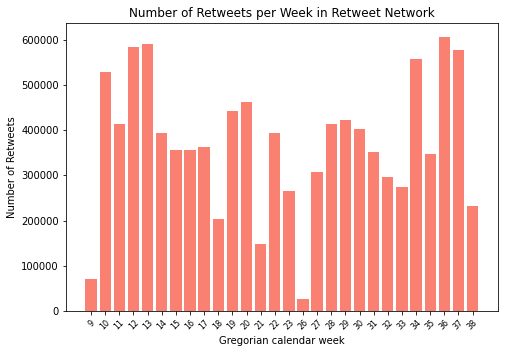

In [ ]:

# Create plot for number of retweets
month_dict = {1: "January", 2: "February", 3: "March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"August", 9: "September"}
num_retweets = [len(w) for w in filtered_users_dfs]

weeks = [int(w.iloc[0].week) for w in filtered_users_dfs]
months = [w.time.iloc[0].month for w in filtered_users_dfs]
# print(month_dict2)
weeks, num_retweets, months = (list(t) for t in zip(*sorted(zip(weeks, num_retweets, months))))
months = [month_dict[w] for w in months]
# print(num_retweets)
# weeks = [month_dict[w] for w in weeks]
# print(weeks)
# plt.plot(weeks, num_retweets)
# plt.show()
print(len(weeks))
# print(weeks)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(np.arange(28),num_retweets, color="salmon")
plt.xlabel("Gregorian calendar week")
plt.ylabel("Number of Retweets")
plt.title("Number of Retweets per Week in Retweet Network")
plt.xticks(np.arange(28), labels=weeks, fontsize= 8, rotation = 45)
plt.savefig(os.getcwd() + "/rt_fig.png", bbox_inches = "tight")
plt.show()


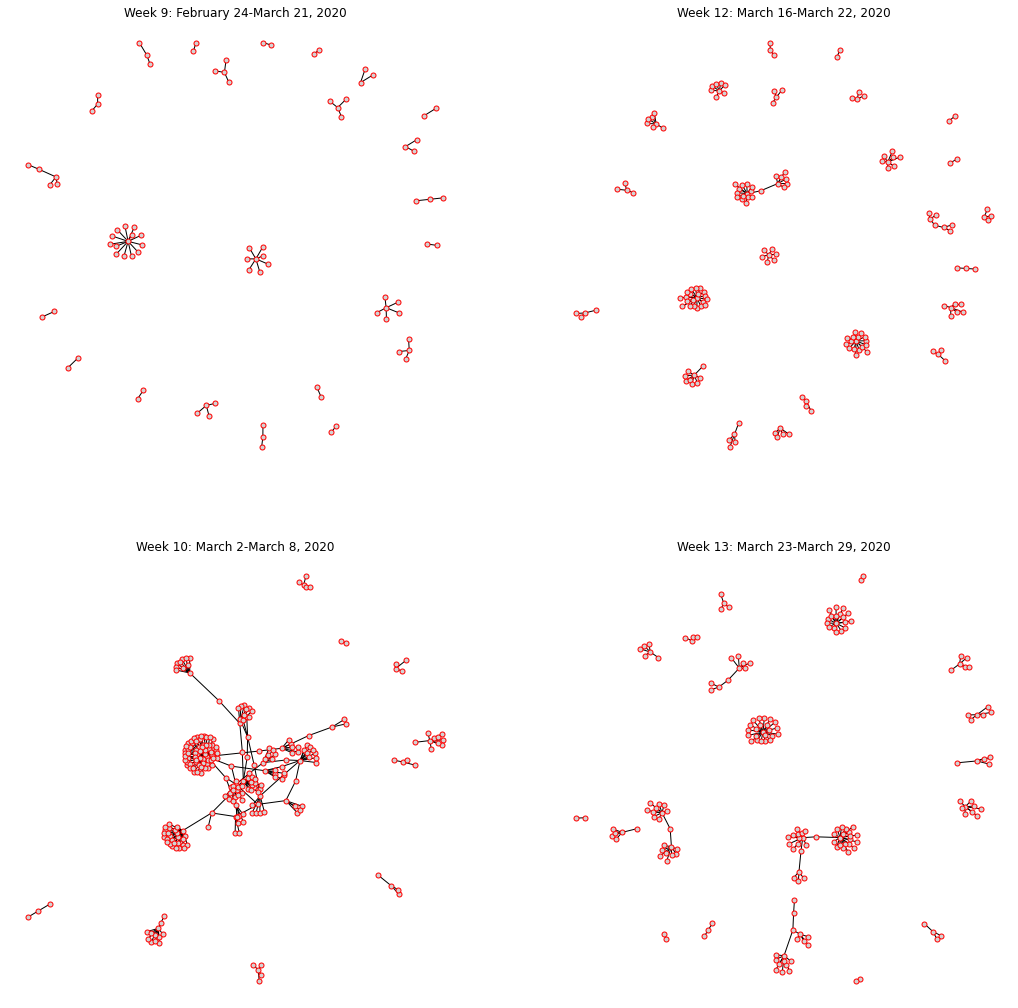

In [ ]:
g1, g2, g3, g4 = filtered_graphs[0], filtered_graphs[1], filtered_graphs[2], filtered_graphs[3]
f = plt.figure(figsize=(18,18))
f.tight_layout()


# Subplot 1
plt.subplot(2, 2, 1)
week1 = filtered_users_dfs_weeks[g1]
nx.draw(g1, edgecolors='red', node_color='lightgray', node_size=25)
plt.title('Week ' + str(int(week1)) + ": February 24-March 21, 2020", fontsize=12)


# Subplot 2
plt.subplot(2, 2, 2)
week2 = filtered_users_dfs_weeks[g2]
nx.draw(g2, edgecolors='red', node_color='lightgray', node_size=25)
plt.title('Week ' + str(int(week2))+ ": March 16-March 22, 2020", fontsize=12)

# Subplot 3
plt.subplot(2, 2, 3)
week3 = filtered_users_dfs_weeks[g3]
nx.draw(g3, edgecolors='red', node_color='lightgray', node_size=25)
plt.title('Week ' + str(int(week3))+ ": March 2-March 8, 2020", fontsize=12)

# Subplot 4
plt.subplot(2, 2, 4)
week4 = filtered_users_dfs_weeks[g4]
nx.draw(g4, edgecolors='red', node_color='lightgray', node_size=25)
plt.title('Week ' + str(int(week4))+ ": March 23-March 29, 2020", fontsize=12)
plt.savefig(os.getcwd() + "/example_networks.png", bbox_inches = "tight")
plt.show()

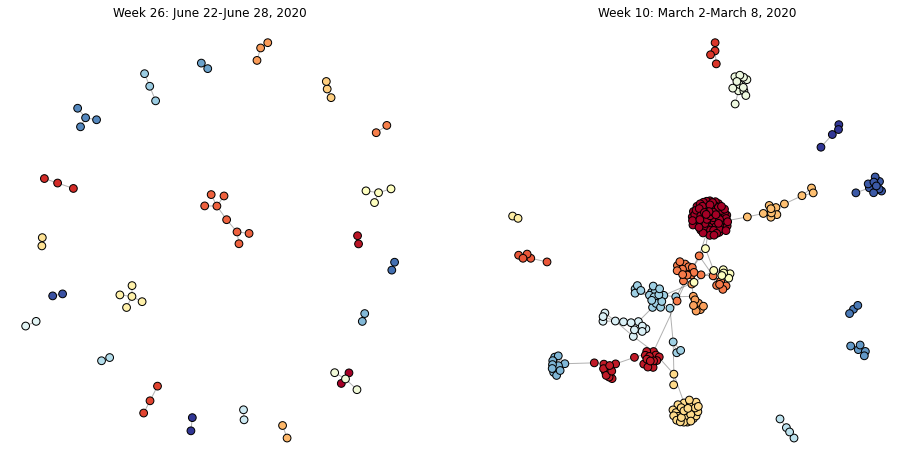

In [ ]:
f = plt.figure(figsize=(16,8))
f.tight_layout()

plt.subplot(1, 2, 1)
max_mod_g = filtered_graphs[np.argmax(np.array([community.modularity(community.best_partition(g), g) for g in filtered_graphs]))]
week = int(filtered_users_dfs_weeks[max_mod_g])
partition = community.best_partition(max_mod_g)
pos = nx.spring_layout(max_mod_g)
plt.axis('off')
nx.draw_networkx_nodes(max_mod_g, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(partition.values()), edgecolors="black")
nx.draw_networkx_edges(max_mod_g, pos, alpha=0.3)
plt.title('Week ' + str(int(week))+ ": June 22-June 28, 2020", fontsize=12)

plt.subplot(1,2,2)
min_mod_g = filtered_graphs[np.argmin(np.array([community.modularity(community.best_partition(g), g) for g in filtered_graphs]))]
week = int(filtered_users_dfs_weeks[min_mod_g])
partition = community.best_partition(min_mod_g)
pos = nx.spring_layout(min_mod_g)
plt.axis('off')
nx.draw_networkx_nodes(min_mod_g, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(partition.values()), edgecolors="black")
nx.draw_networkx_edges(min_mod_g, pos, alpha=0.3)
plt.title('Week ' + str(int(week))+ ": March 2-March 8, 2020", fontsize=12)

plt.savefig(os.getcwd() + "/community_color_networks.png", bbox_inches = "tight")
plt.show()

real community detection

In [ ]:
communities_filtered = {}
for g in filtered_graphs:
  week = filtered_users_dfs_weeks[g]
  part = community.best_partition(g)
  mod = community.modularity(part, g)
  communities_filtered[week] = mod


In [ ]:
num_nodes = [g.number_of_nodes() for g in filtered_graphs]
num_edges = [g.number_of_edges() for g in filtered_graphs]
ccs = [nx.number_connected_components(g) for g in filtered_graphs]
mod = [m for m in communities_filtered.values()]
w = [filtered_users_dfs_weeks[g] for g in filtered_graphs]


w, num_nodes, num_edges, ccs, mod= (list(t) for t in zip(*sorted(zip(w, num_nodes, num_edges, ccs, mod))))

summary_stats = {"Week": w, "# Nodes": num_nodes, "# Edges": num_edges, "# CCs": ccs, "Modularity": mod}
ss_df = pd.DataFrame(summary_stats)
ss_df.to_latex(index=False)

'\\begin{tabular}{rrrrr}\n\\toprule\n Week &  \\# Nodes &  \\# Edges &  \\# CCs &  Modularity \\\\\n\\midrule\n  9.0 &       87 &       63 &     24 &    0.914792 \\\\\n 10.0 &      262 &      258 &     10 &    0.802715 \\\\\n 11.0 &      190 &      169 &     22 &    0.900658 \\\\\n 12.0 &      163 &      139 &     24 &    0.910247 \\\\\n 13.0 &      188 &      168 &     20 &    0.905614 \\\\\n 14.0 &      189 &      168 &     21 &    0.907649 \\\\\n 15.0 &      220 &      204 &     17 &    0.877533 \\\\\n 16.0 &      234 &      220 &     17 &    0.882972 \\\\\n 17.0 &      226 &      210 &     17 &    0.869142 \\\\\n 18.0 &      182 &      164 &     19 &    0.908149 \\\\\n 19.0 &      191 &      175 &     16 &    0.889656 \\\\\n 20.0 &      213 &      197 &     17 &    0.871320 \\\\\n 21.0 &      132 &      109 &     23 &    0.891405 \\\\\n 22.0 &      123 &      102 &     21 &    0.918800 \\\\\n 23.0 &      164 &      143 &     22 &    0.887070 \\\\\n 26.0 &       65 &       42 &     

In [ ]:
communities_filtered

{9.0: 0.914792387543253,
 10.0: 0.802714658642285,
 11.0: 0.9006582517813063,
 12.0: 0.910247253681597,
 13.0: 0.9056136851217584,
 14.0: 0.9076485955645393,
 15.0: 0.8775328469433988,
 16.0: 0.8829719217859238,
 17.0: 0.8691420434318263,
 18.0: 0.9081489444295142,
 19.0: 0.8896563930364159,
 20.0: 0.8713195945162896,
 21.0: 0.8914049586776859,
 22.0: 0.9187997256515776,
 23.0: 0.8870701710351756,
 26.0: 0.9323958896700921,
 27.0: 0.9022129684711482,
 28.0: 0.8715518904320989,
 29.0: 0.8987348615916956,
 30.0: 0.8790354697395973,
 31.0: 0.8472822437630203,
 32.0: 0.8869165023011175,
 33.0: 0.8075739644970414,
 34.0: 0.8670089594875346,
 35.0: 0.8980147406382941,
 36.0: 0.8970981978914194,
 37.0: 0.8769529100220783,
 38.0: 0.8975466524302943}

In [ ]:
entropies = {}

In [ ]:
print(os.getcwd())
weeks = [w.time.iloc[0].week for w in filtered_users_dfs]
weeks1 = {}
for i in range(len(filtered_users_dfs)):
  week = filtered_users_dfs[i].week.iloc[0]
  # print(week)
  with open(os.getcwd() + '/predictions_week' + str(week) + '.txt') as in_file:
    predictions = []
    num0 = 0
    num1 = 0
    for line in in_file:
      l = line.replace('[','').replace(']', '').strip().split(' ')
      prob = [float(l[0]), float(l[len(l)-1])]
      label = np.argmax(prob)
      if label == 0:
        num0+= 1
      if label== 1:
        num1 += 1
      predictions.append(label)
    # weeks1[week] = (num0, num1)
    ent = entropy(predictions)
    entropies[week] = ent
  in_file.close()


/content/gdrive/My Drive/ML Research ListerVosoughi/SMIP/Data


In [ ]:
modularities = {}

In [ ]:
print(len(communities_filtered))
print(len(filtered_users_dfs))
for i in range(len(filtered_users_dfs)):
  w = filtered_users_dfs[i]
  print(w.week.iloc[0])
  mod = communities_filtered[w.week.iloc[0]]
  modularities[w.week.iloc[0]] = mod



28
28
9.0
12.0
10.0
13.0
14.0
11.0
15.0
16.0
17.0
18.0
20.0
19.0
22.0
21.0
23.0
26.0
30.0
29.0
27.0
28.0
31.0
34.0
33.0
35.0
32.0
38.0
37.0
36.0


In [ ]:
modularities

{9.0: 0.914792387543253,
 10.0: 0.802714658642285,
 11.0: 0.9006582517813063,
 12.0: 0.910247253681597,
 13.0: 0.9056136851217584,
 14.0: 0.9076485955645393,
 15.0: 0.8775328469433988,
 16.0: 0.8829719217859238,
 17.0: 0.8691420434318263,
 18.0: 0.9081489444295142,
 19.0: 0.8896563930364159,
 20.0: 0.8713195945162896,
 21.0: 0.8914049586776859,
 22.0: 0.9187997256515776,
 23.0: 0.8870701710351756,
 26.0: 0.9323958896700921,
 27.0: 0.9022129684711482,
 28.0: 0.8715518904320989,
 29.0: 0.8987348615916956,
 30.0: 0.8790354697395973,
 31.0: 0.8472822437630203,
 32.0: 0.8869165023011175,
 33.0: 0.8075739644970414,
 34.0: 0.8670089594875346,
 35.0: 0.8980147406382941,
 36.0: 0.8970981978914194,
 37.0: 0.8769529100220783,
 38.0: 0.8975466524302943}

In [ ]:
# normed_mod = [float(i)/max(modularities) for i in modularities]
# dict(sorted(modularities.items(), key=lambda item: item[1]))
# print(len(sorted_mod))
sorted_mod= sorted(modularities.items(), key=lambda item: item[1])
group_size = len(sorted_mod) // 3
print(group_size)

low_mod = sorted_mod[:group_size]
med_mod = sorted_mod[group_size:2*group_size]
high_mod = sorted_mod[2*group_size:]
print(len(low_mod))
print(len(med_mod))
print(len(high_mod))
print(low_mod)



9
9
9
10
[(10.0, 0.802714658642285), (33.0, 0.8075739644970414), (31.0, 0.8472822437630203), (34.0, 0.8670089594875346), (17.0, 0.8691420434318263), (20.0, 0.8713195945162896), (28.0, 0.8715518904320989), (37.0, 0.8769529100220783), (15.0, 0.8775328469433988)]


In [ ]:
sorted_ent= sorted(entropies.items(), key=lambda item: item[1])
# sorted_ent

low_ent = sorted_ent[:group_size]
med_ent = sorted_ent[group_size:2*group_size]
high_ent = sorted_ent[2*group_size:]
print(len(low_ent))
print(len(med_ent))
print(len(high_ent))
print(low_ent)

9
9
10
[(26.0, 10.196791293755963), (9.0, 11.17616518686905), (21.0, 11.906162784118516), (18.0, 12.21759599596481), (38.0, 12.347771840653685), (23.0, 12.488424286440852), (33.0, 12.51465600623498), (32.0, 12.59385906917783), (27.0, 12.629246687419114)]


In [ ]:
def transition_probability(df, i, j, k): # Get the probability of transitioning from state i to state k given action j.
  # probability = number of times we see state i and action j FOLLOWED BY state k / number of times we see state i and action j

  s_i = df[df['state'] == i]
  s_i_a_j = s_i[s_i['action'] == j]
  c_s_i_a_j = len(s_i_a_j) # number of times we see state i and action j

  c_s_i_a_j_s_k = 0 # number of times we see state i and action j FOLLOWED BY state k
  for idx, row in s_i_a_j.iterrows():
    if (idx+1 in df.index) and df.iloc[idx+1, df.columns.get_loc('state')] == k:
      c_s_i_a_j_s_k += 1
  return c_s_i_a_j_s_k/c_s_i_a_j


In [ ]:
w = []
e = []
m = []
for i in range(len(filtered_users_dfs)):
  week = filtered_users_dfs[i].week.iloc[0]
  w.append(week)
  mod = modularities[week]
  mod_i = sorted_mod.index((week, mod))
  if mod_i < group_size: # low modularity
    m.append(0)
  elif mod_i >= group_size and mod_i < 2*group_size:
    m.append(1)
  else:
    m.append(2)

  ent = entropies[week]
  ent_i = sorted_ent.index((week, ent))
  if ent_i < group_size: # low modularity
    e.append(0)
  elif ent_i >= group_size and ent_i < 2*group_size:
    e.append(1)
  else:
    e.append(2)

env = pd.DataFrame()
env['week'] = w
env['state'] = m
env['action'] = e

env = env.sort_values(by=['week']).reset_index(drop=True)

n_states = 3
n_actions = 3

## **MAX ENT IRL**

In [ ]:
def reward(state_int, n_states=3):
  if state_int == n_states-1:
    return 0
  else: return 1

In [ ]:
def generate_trajectories(n_trajectories, env):
  t_len = len(env) // n_trajectories
  trajectories = []
  t = []
  # print(t_len)
  for idx, row in env.iterrows():
    if idx % t_len == 0 and idx != 0:
      trajectories.append(t)
      t = []
      state = int(row.state)
      action = int(row.action)
      r_ = reward(state)
      t.append((state, action, r_))
    else:
      state = int(row.state)
      action = int(row.action)
      r_ = reward(state)
      t.append((state, action, r_))
  if len(t) == t_len:
    trajectories.append(t)
  return trajectories, t_len

In [ ]:
os.chdir('/content/gdrive/My Drive/')
covid_info_file = 'national-history.csv'
covid_df = pd.read_csv(covid_info_file, header=0, low_memory=False)

In [ ]:
covid_df.head()

,date,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,positive,positiveIncrease,states,totalTestResults,totalTestResultsIncrease
0,2021-03-07,515151.0,842,45475.0,8134.0,726,40199.0,776361.0,74582825.0,131835,4281.0,2802.0,28756489.0,41835,56,363825123,1170059
1,2021-03-06,514309.0,1680,45453.0,8409.0,503,41401.0,775635.0,74450990.0,143835,4280.0,2811.0,28714654.0,60015,56,362655064,1430992
2,2021-03-05,512629.0,2221,45373.0,8634.0,2781,42541.0,775132.0,74307155.0,271917,4275.0,2889.0,28654639.0,68787,56,361224072,1744417
3,2021-03-04,510408.0,1743,45293.0,8970.0,1530,44172.0,772351.0,74035238.0,177957,4267.0,2973.0,28585852.0,65487,56,359479655,1590984
4,2021-03-03,508665.0,2449,45214.0,9359.0,2172,45462.0,770821.0,73857281.0,267001,4260.0,3094.0,28520365.0,66836,56,357888671,1406795


In [ ]:
covid_df['date'] = pd.to_datetime(covid_df['date'], errors='coerce')
print(len(covid_df))
weeks = []
years = []
for idx, row in covid_df.iterrows():
  w = row['date'].isocalendar()[1]
  y = row['date'].isocalendar()[0]
  weeks.append(w)
  years.append(y)
covid_df['week'] = weeks
covid_df['year'] = years

420


In [ ]:
covid_df.head()

,date,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,positive,positiveIncrease,states,totalTestResults,totalTestResultsIncrease,week,year
0,2021-03-07,515151.0,842,45475.0,8134.0,726,40199.0,776361.0,74582825.0,131835,4281.0,2802.0,28756489.0,41835,56,363825123,1170059,9,2021
1,2021-03-06,514309.0,1680,45453.0,8409.0,503,41401.0,775635.0,74450990.0,143835,4280.0,2811.0,28714654.0,60015,56,362655064,1430992,9,2021
2,2021-03-05,512629.0,2221,45373.0,8634.0,2781,42541.0,775132.0,74307155.0,271917,4275.0,2889.0,28654639.0,68787,56,361224072,1744417,9,2021
3,2021-03-04,510408.0,1743,45293.0,8970.0,1530,44172.0,772351.0,74035238.0,177957,4267.0,2973.0,28585852.0,65487,56,359479655,1590984,9,2021
4,2021-03-03,508665.0,2449,45214.0,9359.0,2172,45462.0,770821.0,73857281.0,267001,4260.0,3094.0,28520365.0,66836,56,357888671,1406795,9,2021


In [ ]:
covid_df = covid_df[covid_df.year == 2020]
weekly_covid_dfs = create_weekly_dfs(covid_df)

[53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30
 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6
  5  4  3]


In [ ]:
nd = []
nh = []
nc = []
d = []
nccs = []
dlcc = []

for g in filtered_graphs:
  week = int(filtered_users_dfs_weeks[g])
  for j in weekly_covid_dfs:
    if j.iloc[0].week == week:
      this_week_cov = j
      break
  nd.append(this_week_cov.deathIncrease.sum()) # number of new covid deaths in a week
  nh.append(this_week_cov.hospitalizedIncrease.sum())
  nc.append(this_week_cov.positiveIncrease.sum())
  d.append(nx.density(g)) # density of retweet network for a week
  nccs.append(nx.number_connected_components(g))
  dlcc.append(nx.density(g.subgraph(max(nx.connected_components(g), key=len))))

In [ ]:
env['newDeaths'] = nd
env['newHospitalizations'] = nh
env['newCases'] = nc
env['graphDensity'] = d
env['numCCs'] = nccs
env['densityLargestCC'] = dlcc

In [ ]:
env.head()

,week,state,action,newDeaths,newHospitalizations,newCases,graphDensity,numCCs,densityLargestCC
0,9.0,2,0,8,0,34,0.016840,24,0.142857
1,10.0,0,2,400,590,34070,0.010528,24,0.090909
2,11.0,2,1,23,6,715,0.007546,10,0.009655
3,12.0,2,2,2358,3997,111018,0.009557,20,0.052632
4,13.0,2,2,7780,8750,191278,0.009456,21,0.045455


In [ ]:
features = []
for i in range(n_states): # for each state (low modularity, medium modularity, high modularity)
  newDeaths = env[env['state']==i]['newDeaths'].sum()/len(env[env['state']==i]) # take the average of new deaths over weeks that are in this state
  newHospitalizations = env[env['state']==i]['newHospitalizations'].sum()/len(env[env['state']==i])
  newCases = env[env['state']==i]['newCases'].sum()/len(env[env['state']==i])
  graphDensity = env[env['state']==i]['graphDensity'].sum()/len(env[env['state']==i])
  numCCs = env[env['state']==i]['numCCs'].sum()/len(env[env['state']==i])
  densityLargestCC = env[env['state']==i]['densityLargestCC'].sum()/len(env[env['state']==i])
  features.append([newDeaths, newHospitalizations, newCases, graphDensity, numCCs, densityLargestCC])
feature_matrix = np.array(features)
feature_matrix

array([[7.92100000e+03, 1.06138889e+04, 2.68005667e+05, 1.04182934e-02,
        1.78888889e+01, 5.24911862e-02],
       [7.40800000e+03, 1.26130000e+04, 2.52706444e+05, 1.14978376e-02,
        1.82222222e+01, 5.28663910e-02],
       [4.45320000e+03, 7.43650000e+03, 1.72961100e+05, 1.12998460e-02,
        1.95000000e+01, 7.83539703e-02]])

In [ ]:
! git clone https://github.com/MatthewJA/Inverse-Reinforcement-Learning.git

fatal: destination path 'Inverse-Reinforcement-Learning' already exists and is not an empty directory.


In [ ]:
%cd Inverse-Reinforcement-Learning/irl
! ls

/content/gdrive/My Drive/Inverse-Reinforcement-Learning/irl
deep_maxent.py	  __init__.py	 maxent.py  __pycache__
feat_weights.png  linear_irl.py  mdp	    value_iteration.py


In [ ]:
import value_iteration
from itertools import product

import numpy as np
import numpy.random as rn

def irl(feature_matrix, n_actions, discount, transition_probability,
        trajectories, epochs, learning_rate):
    """
    Find the reward function for the given trajectories.
    feature_matrix: Matrix with the nth row representing the nth state. NumPy
        array with shape (N, D) where N is the number of states and D is the
        dimensionality of the state.
    n_actions: Number of actions A. int.
    discount: Discount factor of the MDP. float.
    transition_probability: NumPy array mapping (state_i, action, state_k) to
        the probability of transitioning from state_i to state_k under action.
        Shape (N, A, N).
    trajectories: 3D array of state/action pairs. States are ints, actions
        are ints. NumPy array with shape (T, L, 2) where T is the number of
        trajectories and L is the trajectory length.
    epochs: Number of gradient descent steps. int.
    learning_rate: Gradient descent learning rate. float.
    -> Reward vector with shape (N,).
    """

    n_states, d_states = feature_matrix.shape

    # Initialise weights.
    alpha = rn.uniform(size=(d_states,))

    # Calculate the feature expectations \tilde{phi}.
    feature_expectations = find_feature_expectations(feature_matrix,
                                                     trajectories)

    # Gradient descent on alpha.
    for i in range(epochs):
        # print("i: {}".format(i))
        r = feature_matrix.dot(alpha)
        expected_svf = find_expected_svf(n_states, r, n_actions, discount,
                                         transition_probability, trajectories)
        grad = feature_expectations - feature_matrix.T.dot(expected_svf)

        alpha += learning_rate * grad

    return alpha, feature_matrix.dot(alpha).reshape((n_states,))

def find_svf(n_states, trajectories):
    """
    Find the state visitation frequency from trajectories.
    n_states: Number of states. int.
    trajectories: 3D array of state/action pairs. States are ints, actions
        are ints. NumPy array with shape (T, L, 2) where T is the number of
        trajectories and L is the trajectory length.
    -> State visitation frequencies vector with shape (N,).
    """

    svf = np.zeros(n_states)

    for trajectory in trajectories:
        for state, _, _ in trajectory:
            svf[state] += 1

    svf /= trajectories.shape[0]

    return svf

def find_feature_expectations(feature_matrix, trajectories):
    """
    Find the feature expectations for the given trajectories. This is the
    average path feature vector.
    feature_matrix: Matrix with the nth row representing the nth state. NumPy
        array with shape (N, D) where N is the number of states and D is the
        dimensionality of the state.
    trajectories: 3D array of state/action pairs. States are ints, actions
        are ints. NumPy array with shape (T, L, 2) where T is the number of
        trajectories and L is the trajectory length.
    -> Feature expectations vector with shape (D,).
    """

    feature_expectations = np.zeros(feature_matrix.shape[1])

    for trajectory in trajectories:
        for state, _, _ in trajectory:
            feature_expectations += feature_matrix[state]

    feature_expectations /= trajectories.shape[0]

    return feature_expectations

def find_expected_svf(n_states, r, n_actions, discount,
                      transition_probability, trajectories):
    """
    Find the expected state visitation frequencies using algorithm 1 from
    Ziebart et al. 2008.
    n_states: Number of states N. int.
    alpha: Reward. NumPy array with shape (N,).
    n_actions: Number of actions A. int.
    discount: Discount factor of the MDP. float.
    transition_probability: NumPy array mapping (state_i, action, state_k) to
        the probability of transitioning from state_i to state_k under action.
        Shape (N, A, N).
    trajectories: 3D array of state/action pairs. States are ints, actions
        are ints. NumPy array with shape (T, L, 2) where T is the number of
        trajectories and L is the trajectory length.
    -> Expected state visitation frequencies vector with shape (N,).
    """

    n_trajectories = trajectories.shape[0]
    trajectory_length = trajectories.shape[1]

    # policy = find_policy(n_states, r, n_actions, discount,
    #                                 transition_probability)
    policy = value_iteration.find_policy(n_states, n_actions,
                                         transition_probability, r, discount)

    start_state_count = np.zeros(n_states)
    for trajectory in trajectories:
        start_state_count[trajectory[0, 0]] += 1
    p_start_state = start_state_count/n_trajectories

    expected_svf = np.tile(p_start_state, (trajectory_length, 1)).T
    for t in range(1, trajectory_length):
        expected_svf[:, t] = 0
        for i, j, k in product(range(n_states), range(n_actions), range(n_states)):
            expected_svf[k, t] += (expected_svf[i, t-1] *
                                  policy[i, j] * # Stochastic policy
                                  transition_probability[i, j, k])

    return expected_svf.sum(axis=1)

def softmax(x1, x2):
    """
    Soft-maximum calculation, from algorithm 9.2 in Ziebart's PhD thesis.
    x1: float.
    x2: float.
    -> softmax(x1, x2)
    """

    max_x = max(x1, x2)
    min_x = min(x1, x2)
    return max_x + np.log(1 + np.exp(min_x - max_x))

def find_policy(n_states, r, n_actions, discount,
                           transition_probability):
    """
    Find a policy with linear value iteration. Based on the code accompanying
    the Levine et al. GPIRL paper and on Ziebart's PhD thesis (algorithm 9.1).
    n_states: Number of states N. int.
    r: Reward. NumPy array with shape (N,).
    n_actions: Number of actions A. int.
    discount: Discount factor of the MDP. float.
    transition_probability: NumPy array mapping (state_i, action, state_k) to
        the probability of transitioning from state_i to state_k under action.
        Shape (N, A, N).
    -> NumPy array of states and the probability of taking each action in that
        state, with shape (N, A).
    """

    # V = value_iteration.value(n_states, transition_probability, r, discount)

    # NumPy's dot really dislikes using inf, so I'm making everything finite
    # using nan_to_num.
    V = np.nan_to_num(np.ones((n_states, 1)) * float("-inf"))

    diff = np.ones((n_states,))
    while (diff > 1e-4).all():  # Iterate until convergence.
        new_V = r.copy()
        for j in range(n_actions):
            for i in range(n_states):
                new_V[i] = softmax(new_V[i], r[i] + discount*
                    np.sum(transition_probability[i, j, k] * V[k]
                           for k in range(n_states)))

        # # This seems to diverge, so we z-score it (engineering hack).
        new_V = (new_V - new_V.mean())/new_V.std()

        diff = abs(V - new_V)
        V = new_V

    # We really want Q, not V, so grab that using equation 9.2 from the thesis.
    Q = np.zeros((n_states, n_actions))
    for i in range(n_states):
        for j in range(n_actions):
            p = np.array([transition_probability[i, j, k]
                          for k in range(n_states)])
            Q[i, j] = p.dot(r + discount*V)

    # Softmax by row to interpret these values as probabilities.
    Q -= Q.max(axis=1).reshape((n_states, 1))  # For numerical stability.
    Q = np.exp(Q)/np.exp(Q).sum(axis=1).reshape((n_states, 1))
    return Q

def expected_value_difference(n_states, n_actions, transition_probability,
    reward, discount, p_start_state, optimal_value, true_reward):
    """
    Calculate the expected value difference, which is a proxy to how good a
    recovered reward function is.
    n_states: Number of states. int.
    n_actions: Number of actions. int.
    transition_probability: NumPy array mapping (state_i, action, state_k) to
        the probability of transitioning from state_i to state_k under action.
        Shape (N, A, N).
    reward: Reward vector mapping state int to reward. Shape (N,).
    discount: Discount factor. float.
    p_start_state: Probability vector with the ith component as the probability
        that the ith state is the start state. Shape (N,).
    optimal_value: Value vector for the ground reward with optimal policy.
        The ith component is the value of the ith state. Shape (N,).
    true_reward: True reward vector. Shape (N,).
    -> Expected value difference. float.
    """

    policy = value_iteration.find_policy(n_states, n_actions,
        transition_probability, reward, discount)
    value = value_iteration.value(policy.argmax(axis=1), n_states,
        transition_probability, true_reward, discount)

    evd = optimal_value.dot(p_start_state) - value.dot(p_start_state)
    return evd

In [ ]:
discount, epochs, learning_rate = 0.01, 200, 0.01
trans_prob = np.array(
            [[[transition_probability(env, i, j, k) for k in range(n_states)]
              for j in range(n_actions)]
             for i in range(n_states)])
# trajectories
# feat_weights, r =irl(feature_matrix, n_actions, discount, trans_prob, np.array(trajectories), epochs, learning_rate)
# [newDeaths, newHospitalizations, newCases, graphDensity, numCCs, densityLargestCC]
n_trajectories = list(np.arange(1,28,2))
feat_weight_df = pd.DataFrame(columns=list(np.arange(1,7)))

for n in n_trajectories:
  trajectories, traj_len = generate_trajectories(n, env)
  if traj_len > 1:
    feat_weights, r =irl(feature_matrix, n_actions, discount, trans_prob, np.array(trajectories), epochs, learning_rate)
    if not n == 11:
      feat_weight_df = feat_weight_df.append({1: feat_weights[0], 2: feat_weights[1], 3: feat_weights[2], 4: feat_weights[3],  5:feat_weights[4], 6:feat_weights[5], "trajectoryLength":traj_len}, ignore_index=True)
feat_weight_df


,1,2,3,4,5,6,trajectoryLength
0,-10509.583310,49330.023103,-6172.088413,0.457197,134.922103,1.626108,28.0
1,-1503.046731,10802.357832,560.558025,0.143147,21.491438,0.942199,9.0
2,-679.450339,4060.353185,1537.661801,0.965004,9.744723,0.515117,5.0
3,-445.336428,3158.526410,1285.851863,0.975728,7.245683,0.536936,4.0
4,-178.252222,1533.676857,535.011471,0.158288,2.770556,0.866856,3.0
5,-95.326540,752.445249,213.133060,0.401406,1.430382,0.950804,2.0


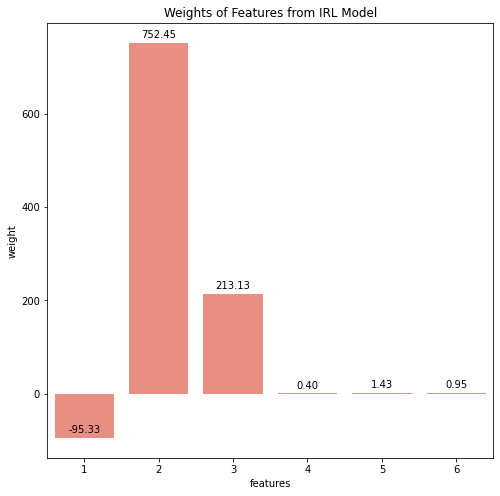

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 8))
x = np.arange(1,7)
y = feat_weight_df[feat_weight_df['trajectoryLength'] == 2.0][[1,2,3,4,5,6]]
feat_df = pd.DataFrame()
feat_df['feature'] = x
feat_df['weight'] = y.values[0]
splot=sns.barplot(x="feature",y="weight",data=feat_df,color="salmon")
for bar in splot.patches:
    splot.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.xlabel("features")
plt.ylabel("weight")
plt.title("Weights of Features from IRL Model")
plt.xticks()
plt.savefig(os.getcwd() + "/feat_weights.png", bbox_inches = "tight")
plt.show()

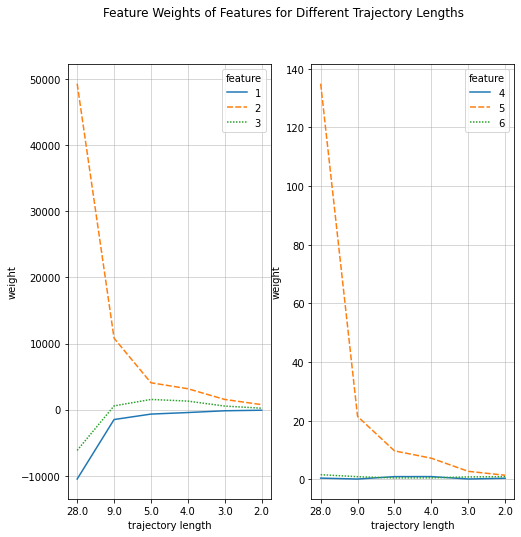

In [ ]:
plt.figure(figsize=(8, 8))
plt.suptitle("Feature Weights of Features for Different Trajectory Lengths")

plt.subplot(1, 2, 1)
g = sns.lineplot(data=feat_weight_df[feat_weight_df.columns[:3]])
g.legend_.set_title('feature')
# plt.title("Feature Weights of Network-Related Features for Different Trajectory Lengths")
plt.xticks(ticks=list(np.arange(len(feat_weight_df))), labels=feat_weight_df.trajectoryLength)
plt.xlabel("trajectory length")
plt.ylabel("weight")
plt.grid(linewidth=0.5)

plt.subplot(1, 2, 2)
h = sns.lineplot(data=feat_weight_df[feat_weight_df.columns[3:6]])
h.legend_.set_title('feature')
plt.xticks(ticks=list(np.arange(len(feat_weight_df))), labels=feat_weight_df.trajectoryLength)
# plt.title("Feature Weights of Network-Related Features for Different Trajectory Lengths")
plt.xlabel("trajectory length")
plt.ylabel("weight")
plt.grid(linewidth=0.5)
plt.savefig(os.getcwd() + "/feat_weights_diff_len.png", bbox_inches = "tight")
plt.show()

In [ ]:
feat_df = pd.DataFrame()
feat_df['Feature'] = np.arange(1,7)
feat_df['Value'] = ['Float']*6
feat_df['Meaning'] = ['Average number of new deaths for this state', 'Average number of new hospitalizations for this state', 'Average number of new cases for this state', 'Average retweet network density for this state', 'Average number of retweet network connected components for this state', 'Average density retweet network largest connected component for this state']
pd.options.display.max_colwidth = 100
print(feat_df.to_latex(index=False))

\begin{tabular}{rll}
\toprule
 Feature &  Value &                                                                     Meaning \\
\midrule
       1 &  Float &                                 Average number of new deaths for this state \\
       2 &  Float &                       Average number of new hospitalizations for this state \\
       3 &  Float &                                  Average number of new cases for this state \\
       4 &  Float &                              Average retweet network density for this state \\
       5 &  Float &       Average number of retweet network connected components for this state \\
       6 &  Float &  Average density retweet network largest connected component for this state \\
\bottomrule
\end{tabular}



In [ ]:
greg_cal_df = pd.DataFrame()
greg_cal_df['Week'] = sorted([int(filtered_users_dfs_weeks[g]) for g in filtered_graphs])
print(sorted([int(filtered_users_dfs_weeks[g]) for g in filtered_graphs]))
greg_cal_df['Dates'] = ['2/24-3/1', '3/2-3/8', '3/9-3/15','3/16-3/22','3/23-3/29', '3/30-4/5', '4/6-4/12', '4/13-4/19', '4/20-4/26', '4/27-5/3', '5/4-5/10', '5/11-5/17', '5/18-5/24', '5/25-5/31', '6/1-6/7', '6/22-6/28', '6/29-7/5', '7/6-7/12', '7/13-7/19', '7/20-7/26','7/27-8/2', '8/3-8/9', '8/10-8/16', '8/17-8/23', '8/24-8/30', '8/31-9/6', '9/7-9/13', '9/14-9/20']
print(greg_cal_df.to_latex(index=False))

[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
\begin{tabular}{rl}
\toprule
 Week &      Dates \\
\midrule
    9 &   2/24-3/1 \\
   10 &    3/2-3/8 \\
   11 &   3/9-3/15 \\
   12 &  3/16-3/22 \\
   13 &  3/23-3/29 \\
   14 &   3/30-4/5 \\
   15 &   4/6-4/12 \\
   16 &  4/13-4/19 \\
   17 &  4/20-4/26 \\
   18 &   4/27-5/3 \\
   19 &   5/4-5/10 \\
   20 &  5/11-5/17 \\
   21 &  5/18-5/24 \\
   22 &  5/25-5/31 \\
   23 &    6/1-6/7 \\
   26 &  6/22-6/28 \\
   27 &   6/29-7/5 \\
   28 &   7/6-7/12 \\
   29 &  7/13-7/19 \\
   30 &  7/20-7/26 \\
   31 &   7/27-8/2 \\
   32 &    8/3-8/9 \\
   33 &  8/10-8/16 \\
   34 &  8/17-8/23 \\
   35 &  8/24-8/30 \\
   36 &   8/31-9/6 \\
   37 &   9/7-9/13 \\
   38 &  9/14-9/20 \\
\bottomrule
\end{tabular}



## **Topic Exposure**

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [ ]:
def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

In [ ]:
def parse_link(url):
  start = url.index('expanded_url') + len('expanded_url')
  end = url.index('display_url')
  start_of_expanded = url[start:end].lower().index('h')
  end_of_expanded = url[start:end].lower().index(',') - 1
  link = url[start:end][start_of_expanded:end_of_expanded]
  return link

In [ ]:
def perform_lda(get_text):
  soup = BeautifulSoup(get_text, "html.parser")
  texts = soup.findAll(text=True)
  visible_texts = filter(tag_visible, texts)
  body_text = u" ".join(t.strip() for t in visible_texts)
  vec = CountVectorizer()
  try:
    tf = vec.fit_transform(re.split(' |\n',clean(body_text)))
  # tf = vec.fit_transform(clean(body_text).split(['\n', ' ']))
    lda = LDA(max_iter=5,learning_method='online',learning_offset=50.,random_state=0)
    lda.fit(tf)
    return lda, vec
  except ValueError:
    return None, None

In [ ]:
def get_top_words(model, feature_names, num):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topics.extend([feature_names[i]
                             for i in topic.argsort()[:-num - 1:-1]])
    return topics

In [ ]:
def find_topics(weekly_df):
  all_topics = []
  for url in weekly_df['linked urls']:
    topics = []
    if url != '[]':
      link = parse_link(url)
      try:
        get_url = rq.get(link)
      except:
        time.sleep(50)
        continue
      code = get_url.status_code
      get_text = get_url.text
      if code == 200:
        lda, vec = perform_lda(get_text)
        if not (lda == None and vec == None):
          topics.extend(get_top_words(lda, vec.get_feature_names(), 5))
        else: topics.extend(['']*50)
    all_topics.append(topics)

  weekly_df_topics = weekly_df.assign(topics = all_topics)
  return weekly_df_topics


In [ ]:
weekly_dfs_with_topics = []
for i in range(len(weekly_dfs)):
  w = weekly_dfs[i]
  w_ = find_topics(w)
  w_.to_csv('all_tweets_with_topics_' + str(i) + '.tsv', index=False, sep='\t')
  weekly_dfs_with_topics.append(w_)

In [ ]:
# weekly_df_topics = find_topics(weeklies[0])

['https://twitter.com/realDailyWire/status/1247896114700800001', 'https://twitter.com/npratc/status/1247988083376549888', 'https://twitter.com/thehill/status/1248084251544870912']


## Community Detection

This was a first attempt at community detection... now deprecated

In [ ]:
communities_generator = nx.algorithms.community.girvan_newman(sample_weekly_graph)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
sorted(map(sorted, next_level_communities))

In [ ]:
# Compute partition
partition = community.best_partition(sample_weekly_graph.to_undirected())

# Get a set of the communities
communities = set(partition.values())

In [ ]:
len(communities)

220053

In [ ]:
# Create a dictionary mapping community number to nodes within that community
communities_dict = {c: [k for k, v in partition.items() if v == c] for c in communities}

# Filter that dictionary to map to first sort the nodes in the community by degree, then take the top 5.
highest_degree = {k: sorted(v, key=lambda x: sample_weekly_graph.degree(x))[-5:] for k, v in communities_dict.items()}

In [ ]:
highest_degree

{0: ['1127220007077797900'],
 1: ['884048368250613800'],
 2: ['1220384458177687600'],
 3: ['1578857004'],
 4: ['1240452287048401000'],
 5: ['1215399878299394000'],
 6: ['16643570'],
 7: ['2573088570'],
 8: ['1167120000286523400'],
 9: ['1006804757875515400'],
 10: ['7703052'],
 11: ['756331456281120800'],
 12: ['2444492244'],
 13: ['1241830099483275300'],
 14: ['2519416129'],
 15: ['2899630090'],
 16: ['1108557386321674200'],
 17: ['1237648756792856600'],
 18: ['928394782426017800'],
 19: ['1000635546'],
 20: ['1176989454428336000'],
 21: ['1011261450164187100'],
 22: ['1475863039'],
 23: ['95399839'],
 24: ['216438127'],
 25: ['1087627519'],
 26: ['1110160568248238100'],
 27: ['874696526'],
 28: ['790033898960920600'],
 29: ['1125412651310276600'],
 30: ['104191265'],
 31: ['1106841274802466800'],
 32: ['2175198895'],
 33: ['1108692890836967400'],
 34: ['1260195841'],
 35: ['1131854274223366100'],
 36: ['4891312721'],
 37: ['2743498930'],
 38: ['288304992'],
 39: ['1090208471809691600

In [ ]:
partition_2 = community.generate_dendrogram(sample_weekly_graph.to_undirected())
# communities_2 = set(partition_2.values())
for level in range(len(partition_2) - 1) :
  communities_2 = set(community.partition_at_level(partition_2, level).values())
  # Create a dictionary mapping community number to nodes within that community
  communities_dict_2 = {c: [k for k, v in community.partition_at_level(partition_2, level).items() if v == c] for c in communities_2}
  highest_degree = {k: sorted(v, key=lambda x: sample_weekly_graph.degree(x))[-5:] for k, v in communities_dict_2.items()}
#     print("partition at level", level,
#           "is", community.partition_at_level(partition_2, level))


# Filter that dictionary to map to first sort the nodes in the community by degree, then take the top 5.
# highest_degree = {k: sorted(v, key=lambda x: sample_weekly_graph.degree(x))[-5:] for k, v in communities_dict_2.items()}

KeyboardInterrupt: ignored

## Write Labels For Pro-/Anti-Mask Classification



In [ ]:
def hashtags_to_list(weekly_df):
  new_hashtag_col = []
  for index, row in weekly_df.iterrows():
    new_hashtags = []
    hashtags = row['hashtags']
    if type(hashtags) is str:
      hashtag_list = hashtags.strip('][').split('\'')
      for i in range(len(hashtag_list)):
        if hashtag_list[i] == 'text':
          hashtag = hashtag_list[i+2]
          new_hashtags.append(hashtag)
      new_hashtag_col.append(new_hashtags)
    else: return weekly_df['hashtags']
  return new_hashtag_col

In [ ]:
print(len(weekly_dfs))
new_df_rows = []
for w in range(len(weekly_dfs)):
  df = weekly_dfs[w]
  for idx, row in df.iterrows():
    row_ = row.to_dict()
    if any(tag in row['hashtags'].lower() for tag in pro_tags):
      row_['mask_label'] = 1
      new_df_rows.append(row_)
    elif any(tag in row['hashtags'].lower() for tag in anti_tags):
      row_['mask_label'] = 0
      new_df_rows.append(row_)
mask_label_df= pd.DataFrame(new_df_rows)
  # print(num_pro)
  # print(num_anti)

32


In [ ]:
print(len(mask_label_df[mask_label_df['mask_label'] == 0]))
print(len(mask_label_df[mask_label_df['mask_label'] == 1]))
mask_label_df.to_csv(os.getcwd() + '/masklabel1.tsv', sep='\t')

968
13900


'/content/gdrive/My Drive/ML Research ListerVosoughi/SMIP/Data'

In [ ]:
new_hashtags = hashtags_to_list(weeklies[w])
pd.options.mode.chained_assignment = None
weeklies[w].loc[:,'hashtags'] = new_hashtags

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
def find_unique_hashtags(weekly_df):
  uniques = {}
  for index, row in weekly_df.iterrows():
    tags = row['hashtags']
    for t in tags:
      if t.lower() in uniques:
        uniques[t.lower()] += 1
      else: uniques[t.lower()] = 1
  return uniques

In [ ]:
# PRINTS ALL UNIQUE HASHTAGS FROM A WEEK IN THEIR ORDER OF OCCURANCE
# all_hashtags = find_unique_hashtags(weeklies[w])
# sorted(all_hashtags.items(), key=operator.itemgetter(1), reverse=True)
anti_tags = set(['nomask', 'burnyourmasks', 'antimask','antimaskers', 'nolockdowns', 'nonewnormal', 'wewillnotcomply'])
pro_tags = set(['wearamask', 'maskssavelives', 'wearadamnmask', 'wearamasksavealife', 'wearyourmask'])

In [ ]:
def create_labels(pro_tags, anti_tags, weekly_df):
  labels = []
  for index, row in weekly_df.iterrows():
    tags = row['hashtags']
    if not pro_tags.isdisjoint(tags): # if there is overlap between protags and anti tags
    # checking this first since a lot of pro mask tweets are backlash to anti mask
      labels.append(1) # promask
    elif not anti_tags.isdisjoint(tags): labels.append(0)
    else: labels.append(-1) # if neither explicitly pro or anti, make -1 so not included in training
 # 1 if pro mask, 0 if anti mask, -1 if neither
  weekly_df['mask_labels'] = labels

In [ ]:
dirpath = os.getcwd()
create_labels(pro_tags, anti_tags, weeklies[w])

In [ ]:
weeklies[w][weeklies[w]['mask_labels'] != -1]

,hashtags,user id,username,name,text,linked urls,bio,retweeted user id,retweet_text,time,week,mask_labels
512364,"[endlockdownuk, endlockdownnow, plandemic, non...",369438464,PeterTownsend2,Peter Townsend,RT @PeterTownsend2: There's no welcome at the ...,[],"In search of truth, justice and liberty. I don...",369438464,There's no welcome at the seaside in this lock...,2020-04-30 17:49:55,18.0,0
629839,"[essentials, sanitised, sanitisedproducts, san...",636879133,CityMallNyali,City Mall,Shop all your #essentials shoprite @citymallny...,"[{'url': 'https://t.co/RF0xb8obW0', 'expanded_...",Mombasa's premier shopping mall is the home to...,,,2020-04-27 10:30:24,18.0,1
1039648,"[wearamask, staysafe, style, ArtistOnTwitter, ...",732902887517528000,AbbyCreates_art,Abby Juli,#wearamask. #staysafe. with #style\n#ArtistOnT...,"[{'url': 'https://t.co/v2ujU6COem', 'expanded_...",Unique and orginal artwork \n💕 Inspired by eve...,,,2020-04-29 13:33:31,18.0,1
1039808,"[quarantine2020, stayconnected, quarantinelife...",17019568,Neita,Neita,Agreed.\nWe need physical distancing but not s...,"[{'url': 'https://t.co/tcWQ1fnMzf', 'expanded_...","Christ Follower, Wife, Momma, Nana, Creative, ...",,,2020-04-29 02:20:41,18.0,1
1157862,"[covid19, Audiologist, coronavírus, StayatHome...",136935214,Audiologydoctor,Dr. Andres Godinez (Audiologist),Breaking news (#covid19)\nExercise caution whe...,[],Doctor of Audiology/ShermanOakshearing.com/\n8...,,,2020-04-28 06:51:00,18.0,1


In [ ]:
this_week = str(int(weeklies[w].iloc[0,10]))
weeklies[w][weeklies[w]['mask_labels'] == -1].to_csv(dirpath + '/' + month + '/' + 'mask_unlabeled' + this_week + '.tsv', sep='\t')

In [ ]:
def compile_mask_labels():
  months = os.listdir(dirpath)
  df_list = []
  for m in months:
    for f in os.listdir(dirpath + '/' + m):
      if f[:10] == 'masklabels':
        path_to_file = dirpath + '/' + m + '/' + f
        these_labels = pd.read_csv(path_to_file, sep='\t', header=0)
        df_list.append(these_labels)
  label_df = pd.concat(df_list).drop('Unnamed: 0', axis=1).reset_index().drop('index', axis=1)
  label_df.to_csv(dirpath + '/' + 'mask_unlabeled.tsv', sep='\t')
  return True

In [ ]:
compile_mask_labels()

NotADirectoryError: ignored